<a href="https://colab.research.google.com/github/charlottevedrines/Java-Projects/blob/main/Lab5_Spam_Detection_vedrines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**. https://drive.google.com/file/d/1gNawc-o1wdkR-74bbRYYLxlJ4SnAdxwt/view?usp=sharing

Colab Link:

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
!pip install torchtext==0.6 torch==1.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 857.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.1
    Uninstalling torchtext-0.17.1:
      Successfully uninstalled torchtext-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.11.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
for line in open('/content/drive/My Drive/APS360/Lab 5/SMSSpamCollection'):
  if line[0] == 's':
    print(line)
    break

for line in open('/content/drive/My Drive/APS360/Lab 5/SMSSpamCollection'):
  if line[0] == 'h':
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



The label value for a spam message is 'spam' and for a non-spam message it's 'ham'

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam = 0
non_span = 0
sanity_check = 0

for line in open('/content/drive/My Drive/APS360/Lab 5/SMSSpamCollection'):
  if line[0] == 's':
    spam += 1
  elif line[0] == 'h':
    non_span +=1
  else:
    sanity_check += 1

print("There are", spam ,"spam messages.")
print("There are", non_span ,"non_span messages.")
print("sanity_check", sanity_check)

There are 747 spam messages.
There are 4827 non_span messages.
sanity_check 0


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

2 advantages:
- Character-level input are not limited by a predefined vocabulary, making the model capable of handling misspelled or slang words that are common in SMS text messages.
- Compared to word-level models, character-level models deal with a much smaller set of tokens allowing for lower dimensionality in the input space.

2 disadvantages:
- Each word is broken into multiple characters resulting into longer sequences to capture the same amount of information as word-level models, resulting in longer training times.
- By focusing on individual characters, it is harder to capture higher-level linguistic features such as word semantics and syntax/.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [6]:
import torch
import torchtext
import spacy

path = '/content/drive/My Drive/APS360/Lab 5/SMSSpamCollection'


text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)
label_field = torchtext.data.LabelField(sequential=False,
                                  use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]


dataset = torchtext.data.TabularDataset(
    path=path,
    format='tsv',
    fields=fields,
    skip_header=False
)

train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2], stratified=True, strata_field='label')

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

A balanced training set helps avoid bias in the predictions to the class that is more represented in the trainng set ultimately leading to the model's better generalization.

In [9]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

text_field.vocab.stoi maps every token to a key in a dictionary (in our case every character) to a unique integer (an ID) as a corresponding value.

text_field.vocab.itos is a list where each element is a character and its indice number is the the character's corresponding value in the text_field.vocab.stoi dictionary.

In [10]:
text_field.build_vocab(train)
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7b6bb015eaa0>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'h': 13,
             '0': 14,
             'd': 15,
             '.': 16,
             'c': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             'b': 25,
             '2': 26,
             'T': 27,
             '8': 28,
             'k': 29,
             'E': 30,
             'v': 31,
             '5': 32,
             'C': 33,
             'S': 34,
             'O': 35,
             'I': 36,
             'N': 37,
             '4': 38,
             'x': 39,
             '7':

In [11]:
#text_field.vocab.itos

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

<unk> token is used to represent 'unknown' characters, characters are not in the training data set.

<pad> token stands for "padding" and is used to fill in the spaces to ensure tha the data input all have the same length when batching them together for training a model.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [12]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [90]:
counter = 0
for batch in train_iter:
    if counter == 10:
        break
    else:
      pad = 0
      print("The maximum length of the input sequence in this batch", int(batch.sms[1][0]))
      for sms in batch.sms[1]:
          pad += batch.sms[1][0] - sms
      print("The number of <pad> tokens =", int(pad))
      print("")
      counter += 1

The maximum length of the input sequence in this batch 157
The number of <pad> tokens = 5

The maximum length of the input sequence in this batch 126
The number of <pad> tokens = 12

The maximum length of the input sequence in this batch 135
The number of <pad> tokens = 26

The maximum length of the input sequence in this batch 155
The number of <pad> tokens = 0

The maximum length of the input sequence in this batch 71
The number of <pad> tokens = 37

The maximum length of the input sequence in this batch 50
The number of <pad> tokens = 8

The maximum length of the input sequence in this batch 35
The number of <pad> tokens = 9

The maximum length of the input sequence in this batch 161
The number of <pad> tokens = 31

The maximum length of the input sequence in this batch 588
The number of <pad> tokens = 8396

The maximum length of the input sequence in this batch 157
The number of <pad> tokens = 0



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [19]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10) # returns a 2-D tensor of size n*m with ones on the diagonal and zeros elsewhere.
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [34]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super(RNN, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [62]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    counter, total = 0, 0
    for batch in train_iter:
        output = model(batch.sms[0])
        prediction = output.max(1, keepdim=True)[1]
        counter += prediction.eq(batch.label.view_as(prediction)).sum().item()
        total += batch.label.shape[0]
    return counter / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [63]:
def get_val_loss(model, valid_loader, criterion):
    total_val_loss = 0.0
    i = 0
    for batch in valid_loader:
        pred = model(batch.sms[0])
        loss = criterion(pred, batch.label)
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/(i + 1)
    return val_loss

Starting training for 20 epochs
Epoch 1: Train acc: 0.49792737522798874, Train loss: 0.7516491524483028 |Validation acc: 0.4808489471066158, Validation loss: 0.7938180487189028
Epoch 2: Train acc: 0.490631736030509, Train loss: 0.7908827242098356 |Validation acc: 0.45995688940474216, Validation loss: 0.933324809703562
Epoch 3: Train acc: 0.5418670203946278, Train loss: 0.790058887318561 |Validation acc: 0.5299287017078428, Validation loss: 0.6966421256462733
Epoch 4: Train acc: 0.5232963024374068, Train loss: 0.7787956474643004 |Validation acc: 0.5218040126015586, Validation loss: 0.9582923596931828
Epoch 5: Train acc: 0.5627590780965014, Train loss: 0.7177789627721435 |Validation acc: 0.5801691261813962, Validation loss: 0.7107583044303788
Epoch 6: Train acc: 0.6738517658763058, Train loss: 0.620861070720773 |Validation acc: 0.6668877466423478, Validation loss: 0.5689892822669612
Epoch 7: Train acc: 0.7184546509699884, Train loss: 0.5765175323737295 |Validation acc: 0.7371911789089703

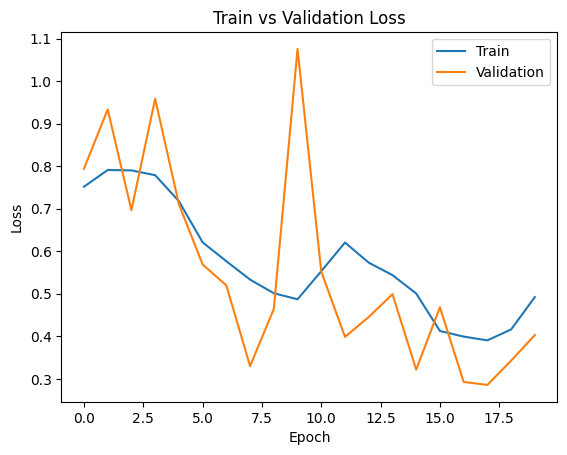

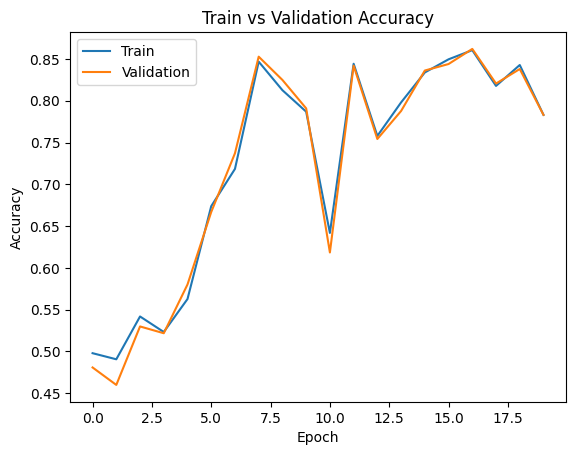

In [64]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=1, lr=0.01):

    torch.manual_seed(2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    val_loss, train_loss, train_acc, val_acc = [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
      total_train_loss = 0.0
      i = 0

      for batch in train_loader:
          messages = batch.sms
          labels = batch.label
          optimizer.zero_grad()
          pred = model(messages[0])
          loss = criterion(pred, labels)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()
          i += 1

      epochs.append(epoch)

      train_acc.append(get_accuracy(model, train_loader))
      train_loss.append(float(total_train_loss)/(i + 1))

      val_acc.append(get_accuracy(model, valid_loader))
      val_loss.append(get_val_loss(model, valid_loader, criterion))

      print(("Epoch {}: Train acc: {}, Train loss: {} |"+
              "Validation acc: {}, Validation loss: {}").format(
                  epoch + 1,
                  train_acc[-1],
                  train_loss[-1],
                  val_acc[-1],
                  val_loss[-1]))

    print('Finished Training')

    # plotting
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

model = RNN(50)


valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

train(model, train_iter, valid_iter, batch_size=64, num_epochs=20, lr=0.01)


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Starting training for 10 epochs
Epoch 1: Train acc: 0.9607030343226662, Train loss: 0.2410504701418655 |Validation acc: 0.9612004642679489, Validation loss: 0.20330059549046886
Epoch 2: Train acc: 0.9767866025534737, Train loss: 0.10296619323964575 |Validation acc: 0.9767866025534737, Validation loss: 0.0465515334573057
Epoch 3: Train acc: 0.9885591112584977, Train loss: 0.07926084449772086 |Validation acc: 0.9883933012767369, Validation loss: 0.07078698184341192
Epoch 4: Train acc: 0.9938650306748467, Train loss: 0.04603401116550422 |Validation acc: 0.9940308406566075, Validation loss: 0.03523836594184912
Epoch 5: Train acc: 0.9878958713314542, Train loss: 0.04467077835579403 |Validation acc: 0.9867352014591279, Validation loss: 0.04199020228568568
Epoch 6: Train acc: 0.9429613662742498, Train loss: 0.19748950768553186 |Validation acc: 0.9429613662742498, Validation loss: 0.26111526632060605
Epoch 7: Train acc: 0.9630243740673189, Train loss: 0.18550595331471414 |Validation acc: 0.963

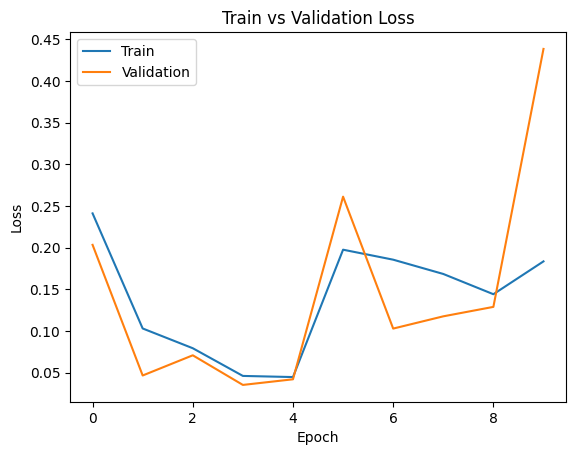

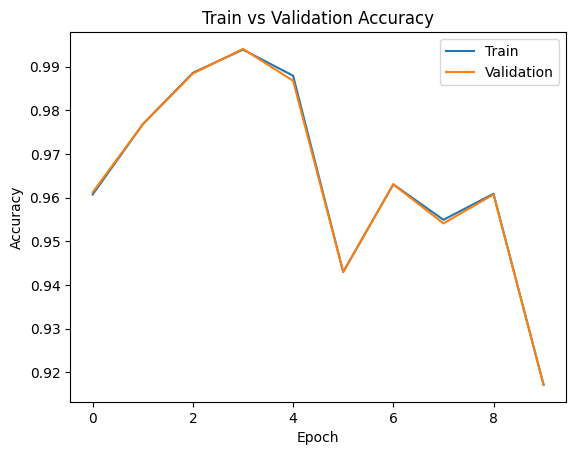

In [65]:
import torch
import torch.nn as nn

class RNN2(nn.Module):
    def __init__(self, hidden_size):
        super(RNN2, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 2)

    def forward(self, x):
      x = self.emb[x]
      h0 = torch.zeros(1, x.size(0), self.hidden_size)
      out, _ = self.rnn(x, h0)
      out_max = torch.max(out, dim=1)[0]
      out_ready_for_fc = torch.cat((out_max, out_max), dim=1)
      return self.fc(out_ready_for_fc)


model2 = RNN2(50)

train(model2, train_iter, valid_iter, batch_size=64, num_epochs=10, lr=0.01)

Starting training for 10 epochs
Epoch 1: Train acc: 0.9670038136295805, Train loss: 0.25377435551368094 |Validation acc: 0.9675012435748632, Validation loss: 0.07350383158255783
Epoch 2: Train acc: 0.9804344221522135, Train loss: 0.09857638662705492 |Validation acc: 0.9809318520974962, Validation loss: 0.09263498147225215
Epoch 3: Train acc: 0.9714806831371249, Train loss: 0.06662454475238185 |Validation acc: 0.9719781130824076, Validation loss: 0.18964186828169557
Epoch 4: Train acc: 0.9233957884264633, Train loss: 0.43270837086847197 |Validation acc: 0.9230641684629415, Validation loss: 0.08798222367962201
Epoch 5: Train acc: 0.9369922069308573, Train loss: 0.18757992123351677 |Validation acc: 0.9369922069308573, Validation loss: 0.07807040592241618
Epoch 6: Train acc: 0.9265461780799205, Train loss: 0.18787628440676551 |Validation acc: 0.9263803680981595, Validation loss: 0.0918469211190111
Epoch 7: Train acc: 0.9253855082075941, Train loss: 0.16539147682487965 |Validation acc: 0.92

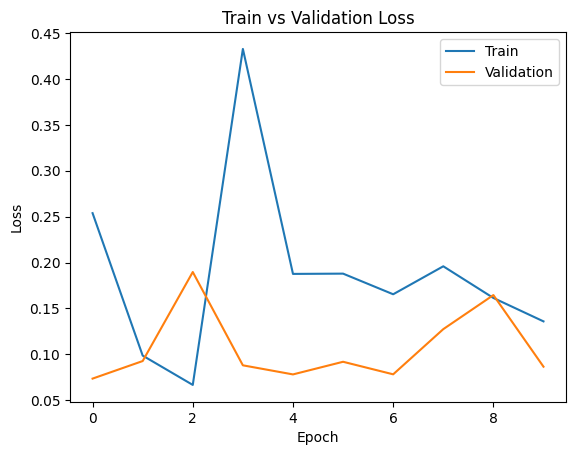

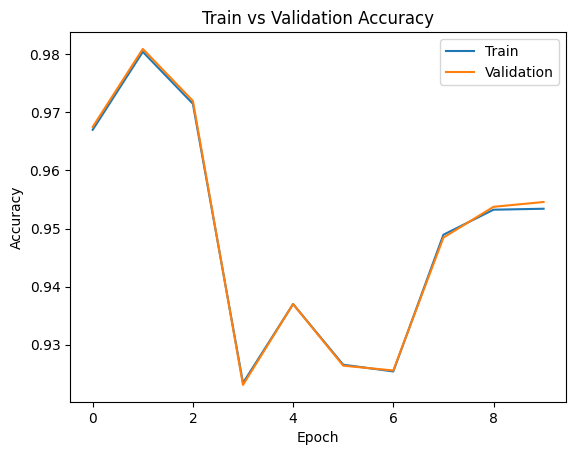

In [66]:
import torch
import torch.nn as nn

class RNN3(nn.Module):
    def __init__(self, hidden_size):
        super(RNN3, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 2)

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

model3 = RNN3(50)

train(model3, train_iter, valid_iter, batch_size=64, num_epochs=10, lr=0.01)

Starting training for 30 epochs
Epoch 1: Train acc: 0.5743657768197645, Train loss: 0.7779011344046969 |Validation acc: 0.5743657768197645, Validation loss: 0.9288678483830558
Epoch 2: Train acc: 0.8232465594428785, Train loss: 0.5315943251805086 |Validation acc: 0.8235781794064002, Validation loss: 0.49656955287274385
Epoch 3: Train acc: 0.48250704692422486, Train loss: 0.4467823824673695 |Validation acc: 0.4826728569059857, Validation loss: 0.3542213101560871
Epoch 4: Train acc: 0.7837837837837838, Train loss: 0.5549048719045363 |Validation acc: 0.7829547338749793, Validation loss: 0.6927951781286134
Epoch 5: Train acc: 0.7827889238932184, Train loss: 0.42402820845416406 |Validation acc: 0.7811308240756093, Validation loss: 0.792110935629656
Epoch 6: Train acc: 0.7927375227988724, Train loss: 0.3999616774440112 |Validation acc: 0.7934007627259161, Validation loss: 0.21463581578670224
Epoch 7: Train acc: 0.8622119051566904, Train loss: 0.3296430352857753 |Validation acc: 0.86436743491

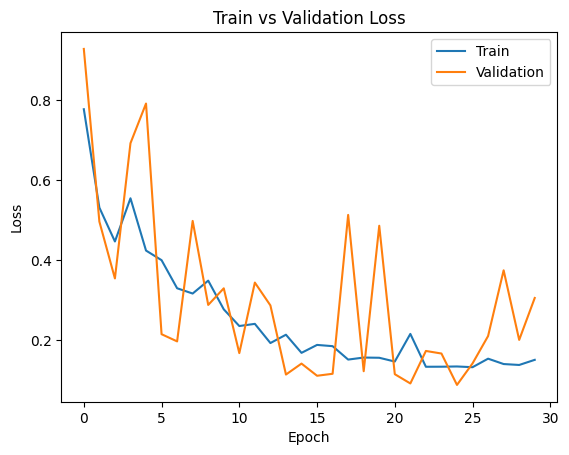

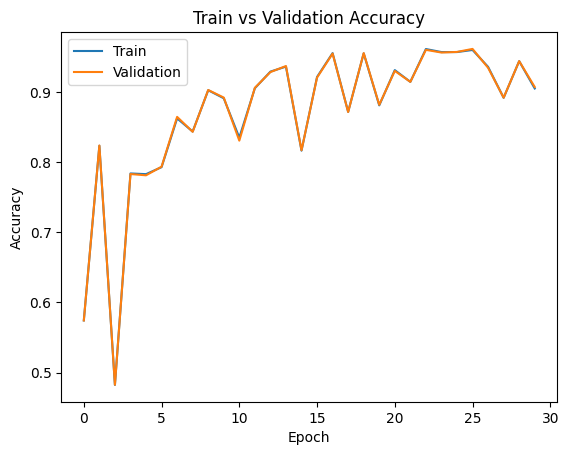

In [67]:
model4 = RNN3(100)

train(model4, train_iter, valid_iter, batch_size=64, num_epochs=30, lr=0.01)

Starting training for 30 epochs
Epoch 1: Train acc: 0.4800198971978113, Train loss: 0.8636252831471594 |Validation acc: 0.4800198971978113, Validation loss: 0.38410177785489297
Epoch 2: Train acc: 0.47968827723428953, Train loss: 0.8412281918486363 |Validation acc: 0.4803515171613331, Validation loss: 0.4308296466867129
Epoch 3: Train acc: 0.6416846294146907, Train loss: 0.8444986829739431 |Validation acc: 0.6418504393964517, Validation loss: 1.050466087129381
Epoch 4: Train acc: 0.6168131321505554, Train loss: 0.7895261522382497 |Validation acc: 0.6168131321505554, Validation loss: 0.3297523320135143
Epoch 5: Train acc: 0.8283866688774664, Train loss: 0.49110347410958066 |Validation acc: 0.8285524788592273, Validation loss: 0.19519256769369045
Epoch 6: Train acc: 0.9280384679157685, Train loss: 0.30113726079365927 |Validation acc: 0.9283700878792903, Validation loss: 0.21727150150885186
Epoch 7: Train acc: 0.9416348864201625, Train loss: 0.21332586903713252 |Validation acc: 0.94130326

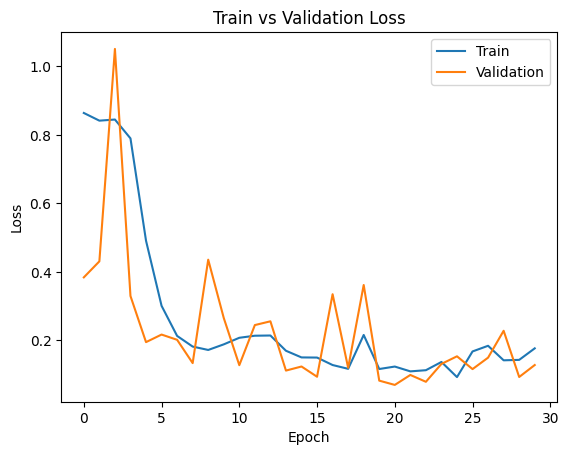

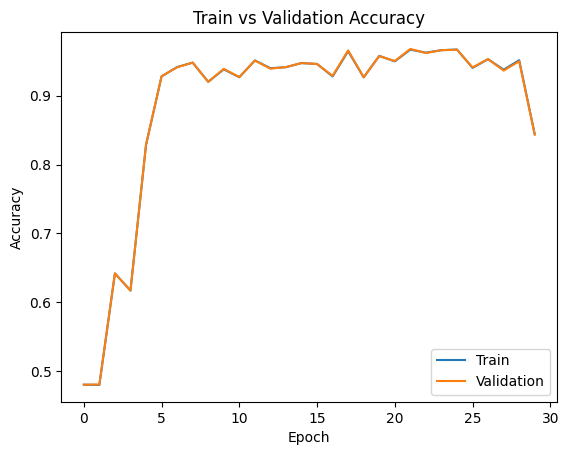

In [68]:
model5 = RNN3(100)

train(model5, train_iter, valid_iter, batch_size=34, num_epochs=30, lr=0.01)

Starting training for 30 epochs
Epoch 1: Train acc: 0.8990217211076107, Train loss: 0.4268007914682752 |Validation acc: 0.8981926711988062, Validation loss: 0.12696130677229828
Epoch 2: Train acc: 0.9572210247056873, Train loss: 0.16697191005376608 |Validation acc: 0.9565577847786437, Validation loss: 0.11010672410743104
Epoch 3: Train acc: 0.9660089537390151, Train loss: 0.11931726151195012 |Validation acc: 0.9665063836842978, Validation loss: 0.07465114961895677
Epoch 4: Train acc: 0.9791079422981264, Train loss: 0.09919875861194573 |Validation acc: 0.9791079422981264, Validation loss: 0.09192825501991643
Epoch 5: Train acc: 0.981429282042779, Train loss: 0.07939465486591583 |Validation acc: 0.9820925219698226, Validation loss: 0.08341535941387217
Epoch 6: Train acc: 0.9834190018239098, Train loss: 0.05903451257066703 |Validation acc: 0.9837506217874316, Validation loss: 0.06050833876037763
Epoch 7: Train acc: 0.984745481677997, Train loss: 0.04851856215513851 |Validation acc: 0.9860

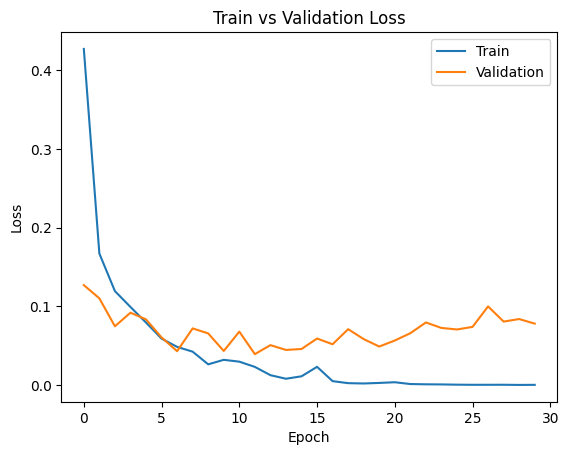

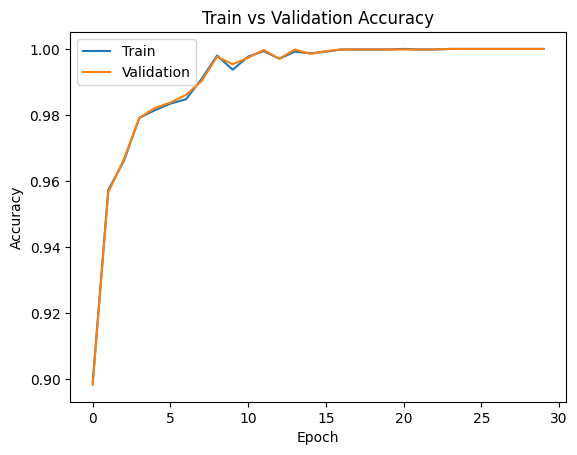

In [69]:
model6 = RNN3(100)

train(model6, train_iter, valid_iter, batch_size=64, num_epochs=30, lr=0.001)

Answer:

4 chosen hyperparameters:
- Method of Pool the RNN outputs: 2 additional pooling methods have been implemented. Max-pool over the entire output array (RNN2, model2) and concatenating the max-pooling and average-pooling of the RNN outputs (RNN3, model3).
- The number of hidden layers: increased from 50 to 100 (model4)
- The learning rate: reduced from 0.01 to 0.001 (model5)
- The batch size: decreased from 64 to 34 (model6)

The best model was model 6 that used RNN3 because that neural network performed best out of the three RNN implemented. RNN3 had 100 hidden states because 100 hidden states yield better results thaan 50. The batch size was kept at 64 because decreasing it worsened results. Decreasing the learning rate, however, from 0.01 to 0.001 helped improve performance.

The validation accuracy is: 1.0.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [72]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

fn, total_spam = 0, 0
for batch in valid_spam_iter:
    output = model3(batch.sms[0])
    pred = output.max(1, keepdim=True)[1]
    fn += pred.ne(batch.label.view_as(pred)).sum().item()
    total_spam += batch.label.shape[0]

fnr = fn / total_spam
print("False Negative Rate:", fnr)


# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)


valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
fp, total_nonspam = 0, 0
for batch in valid_nospam_iter:
    output = model3(batch.sms[0])
    pred = output.max(1, keepdim=True)[1]
    # Increment FP if prediction is not equal to label (non-spam labeled as spam)
    fp += pred.ne(batch.label.view_as(pred)).sum().item()
    total_nonspam += batch.label.shape[0]

fpr = fp / total_nonspam
print("False Positive Rate:",fpr)

False Negative Rate: 0.04666666666666667
False Positive Rate: 0.02694300518134715


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

Answer:

A false positive would result in a SMS text message being removed eventhough they were not spam messages. The impact could be the user never receiving messages which jeopardizes the user's communication system.

On the other hand, a false negative would result in a SMS text message being opened by the user eventhough it is a spam message which defeats the purpose of having a spam detection algorithm.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [73]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_acc = get_accuracy(model3, test_iter )
print("The test accuracy of the model is", test_acc)

The test accuracy of the model is 0.9532415851434256


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [74]:
fp, fn, tn, tp = 0, 0, 0, 0

# False positive rate
for batch in valid_nospam_iter:
    output = model3(batch.sms[0])
    pred = output.max(1, keepdim=True)[1]
    tn += pred.eq(batch.label.view_as(pred)).sum().item()
    fp += pred.ne(batch.label.view_as(pred)).sum().item()

fpr = fp / (fp + tn)
print("FPR:", fpr)


# False negative rate
fp, fn, tn, tp = 0, 0, 0, 0
for batch in valid_spam_iter:
    output = model3(batch.sms[0])
    pred = output.max(1, keepdim=True)[1]
    tp += pred.eq(batch.label.view_as(pred)).sum().item()
    fn += pred.ne(batch.label.view_as(pred)).sum().item()

fnr = fn / (tp + fn)
print("FNR:", fnr)


FPR: 0.02694300518134715
FNR: 0.04666666666666667


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [92]:
msg = "machine learning is sooo cool!"

translate = []

for h in range(len(msg)):
  translate.append(text_field.vocab.stoi[msg[h]])

input_tensor = torch.tensor([translate], dtype=torch.long)

input_tensor = input_tensor.to(next(model3.parameters()).device)

out = model3(input_tensor)

probabilities = F.softmax(out, dim=1)
spam_probability = probabilities[0][1].item()


print("Probability that the message is a spam", spam_probability)

Probability that the message is a spam 0.005965969990938902


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is not a difficult task because a) It is a binary classification task where each class has distinct features and b) there is a lot of labeled datasets of spam and non spam messages.

A simple baseline model would be a logistic regression model Steps include preprocessing the data, importing the model from PyTorch, training it and tuning its hyperparameters.

